## Analyse and Classify Domains

In this notebook, we will analyse and classify the domains retrieved from the preprocessing steps.

We now have in our hands a list of domains for each video and a sponsor score determining if the video description contains a sponsorship-related theme. We do the following:

1. Firstly, we perform an overall analysis of the domains and find their average sponsor score.

2. In a second step, we take the most popular domains occurring in at least $10'000$ videos. We classify them into categories and determine if they are sponsor-related or not. In this step, the average sponsor score might be a good indicator.

3. ...

In [1]:
import findspark
findspark.init()

import numpy as np
import seaborn as sns

from pyspark.sql.functions import explode, udf, count, collect_list
from pyspark.sql.types import FloatType

import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
import pyspark as ps
config = ps.SparkConf()
config.set('spark.executor.heartbeatInterval', '3600s')
config.set('spark.network.timeout', '7200s')
config.set('spark.driver.memory', '16g')
sc = ps.SparkContext('local[*]', '', conf=config) # write 'local' for single-threaded execution and 'local[*]' for multi-threaded execution
spark = SparkSession(sc)

In [2]:
PATH_METADATAS_DOMAINS_SRC = '../data/generated/yt_metadata_en_domains.parquet'
PATH_METADATAS_SPONSOR_SCORES_SRC = '../data/generated/yt_metadata_en_sponsor_scores.parquet'

In [3]:
metadatas_domains = spark.read.parquet(PATH_METADATAS_DOMAINS_SRC)
metadatas_sponsor_scores = spark.read.parquet(PATH_METADATAS_SPONSOR_SCORES_SRC)
metadatas = metadatas_domains.join(metadatas_sponsor_scores, on='display_id', how='left')

assert metadatas.count() == metadatas_domains.count()

In [7]:
metadatas.dtypes

[('display_id', 'string'),
 ('categories', 'string'),
 ('channel_id', 'string'),
 ('dislike_count', 'int'),
 ('duration', 'int'),
 ('like_count', 'int'),
 ('tags', 'string'),
 ('title', 'string'),
 ('upload_date', 'date'),
 ('view_count', 'bigint'),
 ('domains', 'array<string>'),
 ('domains_count', 'int'),
 ('has_domains', 'string'),
 ('sponsor_score', 'int')]

In [8]:
metadatas.select('display_id', 'domains', 'sponsor_score').show(5)

+-----------+--------------------+-------------+
| display_id|             domains|sponsor_score|
+-----------+--------------------+-------------+
|82fVA65rbts|           [radi.al]|            2|
|Hpxh4XBQBEk|[whatcar.com, sma...|            9|
|K308-reAiTk|[linyibrickmachin...|            2|
|Qit2N489qqk|[whatcar.com, the...|            9|
|VFwTdmiqlmM|[iteachstamping.c...|            1|
+-----------+--------------------+-------------+
only showing top 5 rows



In [12]:
domains_count = metadatas \
    .select(explode('domains').alias('domain')) \
    .groupBy('domain') \
    .count() \
    .orderBy('count', ascending=False)

In [13]:
total_counts = domains_count.select('count').collect()
total_counts = [c[0] for c in total_counts]

print(f"There are a total of {len(total_counts)} domains.")

There are a total of 1077304 domains.


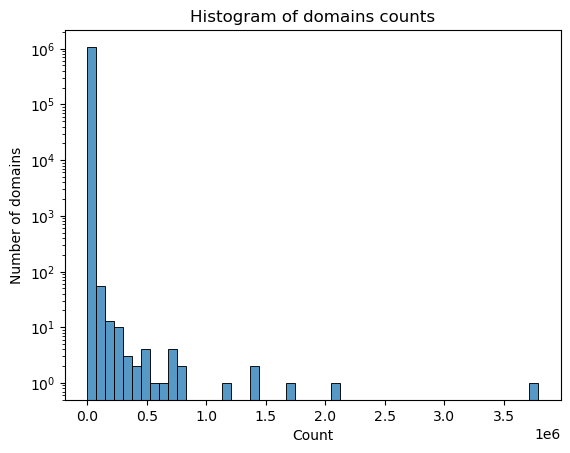

In [11]:
sns.histplot(total_counts, bins=50)
plt.yscale('log')
plt.title('Histogram of domains counts')
plt.xlabel('Count')
plt.ylabel('Number of domains')
plt.show()

In [4]:
def find_median(values_list):
    try:
        median = np.median(values_list)
        return round(float(median), 2)
    except Exception:
        return None

In [7]:
MIN_DOMAIN_COUNT = 10_000

median_udf = udf(find_median, FloatType())

domains_top_count = metadatas \
    .select(explode('domains').alias('domain'), 'sponsor_score') \
    .groupBy('domain') \
    .agg(count('domain').alias('count'), collect_list('sponsor_score').alias('sponsor_scores')) \
    .filter(f'count >= {MIN_DOMAIN_COUNT}') \
    .withColumn('median_sponsor_score', median_udf('sponsor_scores')) \
    .drop('sponsor_scores') \
    .orderBy('count', ascending=False)

In [8]:
domains_top_count.show(10)

+-------------------+-------+--------------------+
|             domain|  count|median_sponsor_score|
+-------------------+-------+--------------------+
|    plus.google.com|3786647|                 3.0|
|    play.google.com|2093786|                 4.0|
|   itunes.apple.com|1724603|                 3.0|
|             bit.ly|1408414|                 3.0|
|        tinyurl.com|1380122|                 4.0|
|          rstyle.me|1175073|                11.0|
| steamcommunity.com| 824573|                 3.0|
|creativecommons.org| 767740|                 4.0|
|        smarturl.it| 750397|                 3.0|
|              po.st| 739548|                 4.0|
+-------------------+-------+--------------------+
only showing top 10 rows



In [9]:
top_counts = domains_top_count.select('count').collect()
top_counts = [c[0] for c in top_counts]

print(f"There are a total of {len(top_counts)} domains with at least {MIN_DOMAIN_COUNT} counts.")

There are a total of 1000 domains with at least 10000 counts.


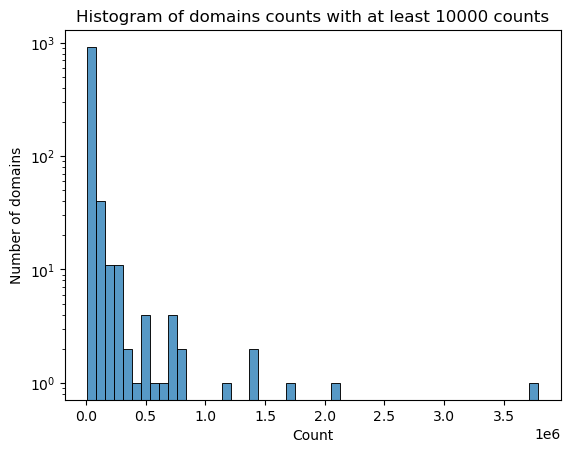

In [14]:
sns.histplot(top_counts, bins=50)
plt.yscale('log')
plt.title(f'Histogram of domains counts with at least {MIN_DOMAIN_COUNT} counts')
plt.xlabel('Count')
plt.ylabel('Number of domains')
plt.show()

Both distributions are **heavy-tailed to the right**. Indeed, there are many domains that appear in some videos only and a small subset of domains seem to prevail in many videos. This is a typical feature of a **power-law distributions**. The **log-log plot** of the distribution of the number of videos per domain is shown below.

Taking only domains that appear in at least $10'000$ videos does not change much the distribution as it might still be considered as a small amount of occurence for a domain. Nevertheless, we end up with only $1'000$ distinct domains to take into account, which is a reasonable amount of data to work with.

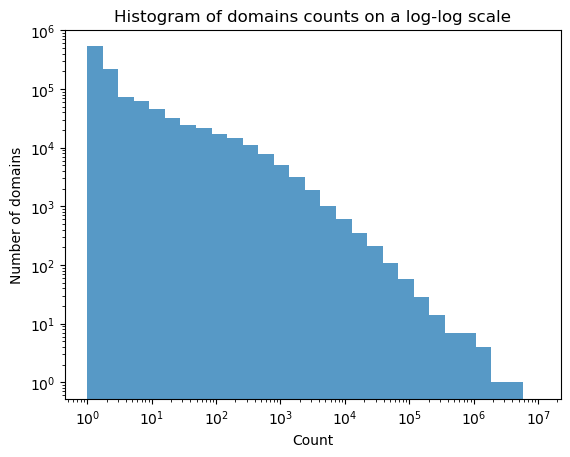

In [15]:
sns.histplot(total_counts, bins=np.logspace(0, 7, 30))
plt.yscale('log')
plt.xscale('log')
plt.title('Histogram of domains counts on a log-log scale')
plt.xlabel('Count')
plt.ylabel('Number of domains')
plt.show()

The distribution of the number of videos per domain follows approximately a straight line in the log-log plot above. It seems to follow a **power-law distribution**.

In [16]:
PATH_METADATAS_TOP_COUNTS_DST = '../data/generated/yt_metadata_en_domains_top_count.parquet'

In [17]:
# Delete the output folder if it already exists
#!rm -f $PATH_METADATAS_TOP_COUNTS_DST # Linux
!PowerShell.exe -Command "Remove-Item -Path $PATH_METADATAS_TOP_COUNTS_DST -Recurse -Force" # Windows

In [18]:
domains_top_count.write.csv(PATH_METADATAS_TOP_COUNTS_DST)